In [8]:
import openseespy.opensees as ops

In [9]:
import numpy as np
import opsvis as ovs

In [10]:
import matplotlib.pyplot as plt

In [21]:
#data in SI
gap = 0.003
m1 = 75*10**3
m2 = 3000*10**3
T1 = 1.2
T2 = 0.3
c1 = 39270
c2 = 6.283*10**6
k1 = 2.056*10**6
k2 = 1.316*10**9

In [22]:
ops.wipe()
ops.model('BasicBuilder', '-ndm', 2, '-ndf', 3)


ops.node(1, 0, 0)
ops.node(2, 0, 0)


gap = 0.03 #0.03m = 30mm
ops.node(3, gap, 0)
ops.node(4, gap, 0)

ops.fix(1, 1, 1, 1)
ops.fix(3, 1, 1, 1)

ops.mass(2, 75.0e3, 0., 0.)
ops.mass(4, 3000.0e3, 0., 0.)


#uniaxialMaterial('Elastic', matTag, E, eta=0.0, Eneg=E)
#LEFT SDOF SYSTEM
ops.uniaxialMaterial('Elastic', 101, 2.056e6) #left stiffness param
ops.uniaxialMaterial('Viscous', 201, 39270, 1) #left damping param
ops.uniaxialMaterial('Parallel', 301, *[101, 201]) #left combined
ops.element('zeroLength', 101, *[1,2], '-mat', 301, '-dir', 1,2, '-orient', 0,1,0,-1,0,0) #element


# RIGHT SDOF SYSTEM
ops.uniaxialMaterial('Elastic', 102, 1.316e9) #right
ops.uniaxialMaterial('Viscous', 202, 6.283e6, 1) #right
ops.uniaxialMaterial('Parallel', 302, *[201, 202]) #right combined
ops.element('zeroLength', 102, *[3,4], '-mat', 302,'-dir', 1,2, '-orient', 0,1,0,-1,0,0) #element


#for kelvin voigt material
ops.uniaxialMaterial('Elastic', 103, 1.316e9) #kelvin voigt
ops.uniaxialMaterial('Viscous', 203, 2669104, 1)
ops.uniaxialMaterial('Parallel', 303, *[103, 203])
# uniaxialMaterial ElasticPPGap $matTag $E $Fy $gap $eta <damage>
ops.uniaxialMaterial('ElasticPPGap', 403, 1.316e9, -250e6, -1*gap, 0.1)
ops.uniaxialMaterial('Series', 503, *[303, 403])


#add kelvin voigt element
ops.node(5, 0, 0)
ops.element('zeroLength', 103, *[2,5], '-mat', 303, '-dir', 1)
ops.equalDOF(2,5,*[2,3])
ops.element('twoNodeLink', 104, *[5, 4], '-mat', 403, '-dir', 1)

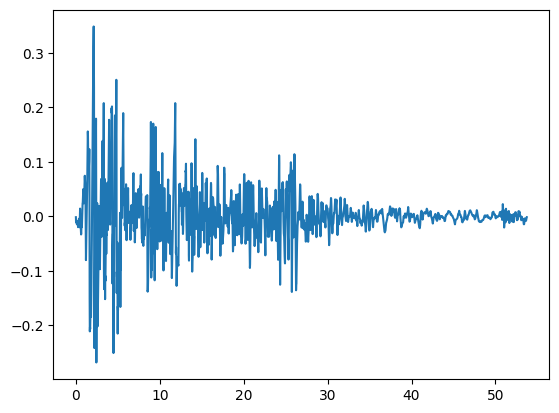

In [23]:
eqData = np.loadtxt('elcentro.txt')
time = eqData[:, 0]
accel = eqData[:, 1]
plt.plot(time, accel)

In [24]:
DtAnalysis = 0.01 #for analysis
TmaxAnalysis = 10 #for analysis
Nstep = int(TmaxAnalysis/DtAnalysis)

GM_dirn = 1
GM_fact = 1.0*9.81
gmTS = 1
dt = 0.01		# time step for input ground motion

ops.timeSeries("Path", gmTS, '-time', *time, '-values', *accel, '-fact', GM_fact)
#pattern('UniformExcitation', patternTag, dir, '-disp', dispSeriesTag, '-vel', velSeriesTag, '-accel', accelSeriesTag, '-vel0', vel0, '-fact', fact)
ops.pattern('UniformExcitation', 1, GM_dirn, '-accel', gmTS)

ops.constraints('Plain')
ops.numberer('RCM')
ops.test('EnergyIncr', 1.0e-10, 100)
ops.algorithm('ModifiedNewton')
ops.system('SparseGEN')



# define DAMPING--------------------------------------------------------------------------------------
# apply Rayleigh DAMPING from $xDamp
# D=$alphaM*M + $betaKcurr*Kcurrent + $betaKcomm*KlastCommit + $beatKinit*$Kinitial
xDamp= 0.02;				# 2% damping ratio
lambda_ =  ops.eigen(1)[0]			# eigenvalue mode 1
omega = pow(lambda_,0.5)
alphaM =  0.				# M-prop. damping; D = alphaM*M
betaKcurr =  0.         			# K-proportional damping;      +beatKcurr*KCurrent
betaKcomm =  2.*xDamp/omega  	# K-prop. damping parameter;   +betaKcomm*KlastCommitt
betaKinit =  0.		# initial-stiffness proportional damping      +beatKinit*Kini
# define damping
ops.rayleigh(alphaM, betaKcurr, betaKinit, betaKcomm) # RAYLEIGH damping
ops.integrator("Newmark", .5, .25)
#ops.integrator("HHT", .5, alphaM, betaKcurr, betaKinit, betaKcomm)
ops.analysis("Transient")

ops.analyze(Nstep, DtAnalysis)

WARNING SuperLU::solve(void)-  Error 1 returned in factorization dgstrf()
WARNING SuperLU::solve(void)-  Error 1 returned in factorization dgstrf()
WARNING SuperLU::solve(void)-  Error 1 returned in factorization dgstrf()
WARNING SuperLU::solve(void)-  Error 3 returned in factorization dgstrf()
WARNING ModifiedNewton::solveCurrentStep() -the LinearSysOfEqn failed in solve()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0.01
OpenSees > analyze failed, returned: -3 error flag


-3

In [25]:
lambda_

3.3333333333333335e-07